In [1]:
from utils import *
from main  import *
from other import *

basicConfig(filename = 'Empirics.log', level = INFO)

In [2]:
outs = {}
for quarter in np.arange(2020.75, 2022.25, .25):
    out = joblib.load('save/emp/%.2f.dat'%quarter)
    outs.update(out)
dates = np.array(list(outs.keys()))

In [3]:
estimators = [BR_estimation, Hardiman, AVG_Hardiman_4, 
              Exp_estimation, EM_estimation,
             ]
names      = ['Ours', 'H&B', 'H&B(2h)', 'MLE(exp)', 'EM']
typ = 'mid_change'
BRs = []
for date in dates:
    ress = outs[date][typ]
    row  = []
    for estimator in estimators:
        row.append(ress[estimator.__name__]['BR'])
    BRs.append(row)
BRs = pd.DataFrame(BRs, index=pd.to_datetime(dates), columns=names)
BRs['year'] = BRs.index.year
RV_1min = pd.Series(([outs[date]['RV(1min)'] for date in dates]),
                    index=pd.to_datetime(dates))
RV_5min = pd.Series(([outs[date]['RV(5min)'] for date in dates]), 
                    index=pd.to_datetime(dates))
intra_ret = pd.Series(
                [(outs[date]['price(last)'] - outs[date]['price(init)'])\
                 / outs[date]['price(init)'] for date in dates], 
                index=pd.to_datetime(dates))
mid_price = pd.Series(
                [(outs[date]['price(last)'] + outs[date]['price(init)']) / 2\
                 for date in dates], 
                index=pd.to_datetime(dates))
volume = pd.Series([outs[date]['volume'] for date in dates], 
                   index=pd.to_datetime(dates))
dollar_volume = pd.Series(([outs[date]['dollar_volume'] for date in dates]),
                          index=pd.to_datetime(dates))
VPIN = pd.Series(([outs[date]['VPIN'] for date in dates]), 
                 index=pd.to_datetime(dates))
nums = pd.Series(([outs[date][typ][estimators[0].__name__]['N']\
                   for date in dates]), index=pd.to_datetime(dates))

In [4]:
# Generic filter
NUM_MIN = 1300
mask = nums > NUM_MIN

In [5]:
def get_z(res, test, ours = 'BR_estimation'):
    return res[ours][test] / res[ours]['SD(%s)'%test]

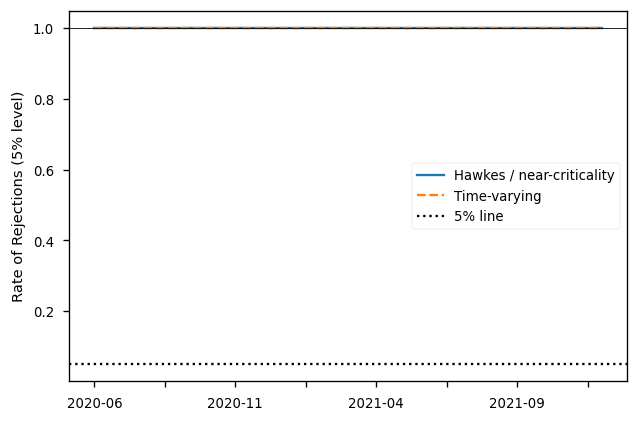

In [6]:
######### Parameters ##########
typ   = 'mid_change'
save  = IMG_PATH + "emp/test_trend_%s.pdf"%typ
tests = ['BR', 'BR - BR_const']
names = ['Hawkes / near-criticality', 'Time-varying']
line_styles = ['-', '--', '-.']
###############################
zs = pd.DataFrame(index=pd.to_datetime(dates))
for i in range(len(tests)):
    zs[names[i]] = [get_z(outs[date][typ], tests[i]) for date in dates]
zs['year'] = zs.index.year

# analysing averages by months
other_ratio = zs[mask]
other_ratio['some'] = [str(val)[:7] for val in other_ratio.index]
test_ratio = other_ratio.groupby('some').apply(
                lambda x: (np.abs(x) > 1.96).sum() / len(x))


del test_ratio['year']
fig = test_ratio.plot(figsize=(6, 4), style=line_styles).get_figure()
plt.ylabel("Rate of Rejections (5% level)")
plt.xlabel("")
#plt.title("Ratio of Test Rejection (%s)"%typ)
plt.axhline(1,   c='black', lw=.5)
plt.axhline(.05, c='black', ls=':', label='5% line')
# plt.ylim(0, 1.1)
plt.legend()
plt.show()

if save != "":
    fig.savefig(save, bbox_inches="tight")

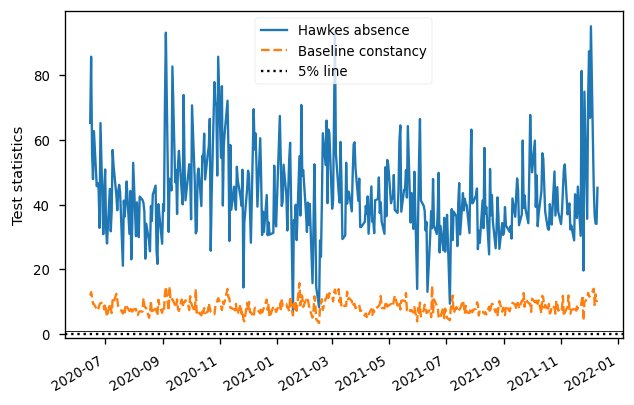

In [7]:
# With no aggregation

######### Parameters ##########
typ   = 'mid_change'
save  = IMG_PATH + "emp/no_agr_test_trend_%s.pdf"%typ
tests = ['BR', 'BR - BR_const', 'IV']
names = ['Hawkes absence', 'Baseline constancy', 'Brownian']
line_styles = ['-', '--', '-.']
###############################
zs = pd.DataFrame(index=pd.to_datetime(dates))
for i in range(len(tests)):
    zs[names[i]] = [get_z(outs[date][typ], tests[i]) for date in dates]
zs['year'] = zs.index.year

# considering statistics without averages finding (daily observations)
other_ratio = zs[mask]
other_ratio['some'] = [str(val)[:7] for val in other_ratio.index]
test_ratio = other_ratio.groupby('some').apply(
                lambda x: x)


test_ratio['Baseline constancy'] = - test_ratio['Baseline constancy']

del test_ratio['year']

# !!!
del test_ratio['Brownian']

fig = test_ratio.plot(figsize=(6, 4), style=line_styles).get_figure()
plt.ylabel("Test statistics")
plt.xlabel("")
#plt.title("Ratio of Test Rejection (%s)"%typ)
plt.axhline(1,   c='black', lw=.5)
plt.axhline(.05, c='black', ls=':', label='5% line')
# plt.ylim(0, 1.1)
plt.legend()
plt.show()

if save != "":
    fig.savefig(save, bbox_inches="tight")

## S&P futures mid-price changes

In [ ]:
# new code for intradays aggregation

names = ['ESH2021','ESM2021','ESU2021','ESZ2021']
points = []

for name in names:
    data = joblib.load('save/E-mini/%s.dat'%name)
    dates = np.array(list(data.keys()))

    for date in dates:
        next_day_points = data[date]['trade'].index.values
        points = np.concatenate([points, next_day_points])

In [9]:
# plot for working hours
the_points = points
working_hours_points = []

lower_limit = 8.5*3600
upper_limit = 15*3600

working_hours_points = [point for point in the_points if point >= lower_limit and point <= upper_limit]

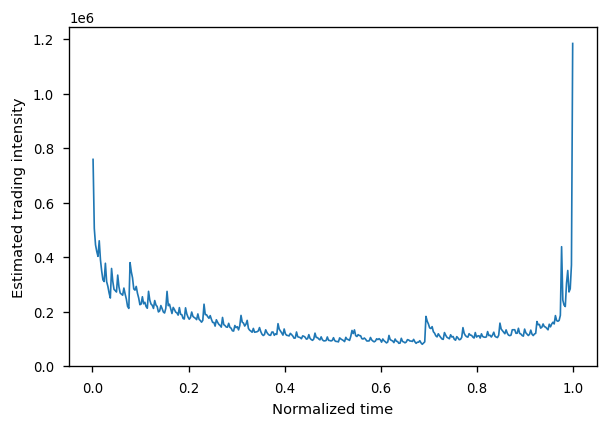

In [ ]:
####### Parameters ########
typ  = 'trade'
save = IMG_PATH + "sim/intensity_plot(%s %s, %s).pdf"%(name, typ, date.replace('/','-'))
###########################

working_hours_points = np.array(working_hours_points)

working_hours_points -= working_hours_points.min()
working_hours_points /= working_hours_points.max()
dN, bins = np.histogram(working_hours_points, bins=390)  # 1 min counting
delta = bins[1] - bins[0]
fig = plt.figure(figsize=(5,3.5)).get_figure()
plt.plot(bins[:-1] + delta/2, dN, lw=1)
# plt.title("Intensity plot")
plt.ylim(0,dN.max()*1.05)
plt.tight_layout()
plt.xlabel('Normalized time')
plt.ylabel('Estimated trading intensity')

if save != "":
    fig.savefig(save, bbox_inches="tight")